In [1]:
import pandas as pd
import os
import numpy as np
import re

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import f1_score, classification_report
from sklearn.feature_extraction.text import CountVectorizer

from gensim.models import KeyedVectors
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *

from matplotlib import pyplot as plt

In [2]:
import networkx as nx
import sys
scripts_dir = os.path.join(os.path.dirname(os.path.abspath('')), 'scripts')
if not scripts_dir in sys.path:
    sys.path.append(scripts_dir)
from get_graph import get_digraph
from CitationRateEncoder import CitationRateEncoder
from past_present_train_test_split import prepare_training_data

Get the training and test data from our graph

In [ ]:
input_date='2001-01-01'
test_frac=0.1
G, df, (train, test) = prepare_training_data(input_date=input_date,test_frac=test_frac)
df = df.drop(columns=['Date', 'Title', 'Authors'])
df.set_index('Paper_ID', inplace=True)
df.head()

Papers after date found by split : 20206


,Abstract,target_citation_rate
Paper_ID,,
1001,These are notes based on lectures given at TAS...,6
1002,We point out that massive gauged supergravity ...,8
1003,"Recently, Ivanov and Volovich (hep-th/9912242)...",1
1004,"Quantum fields responding to ""moving mirrors"" ...",0
1005,Various aspects of spaces of chiral blocks are...,0


Split citations rates into classes

,Abstract,target_citation_rate
Paper_ID,,
1001,These are notes based on lectures given at TAS...,3
1002,We point out that massive gauged supergravity ...,3
1003,"Recently, Ivanov and Volovich (hep-th/9912242)...",1
1004,"Quantum fields responding to ""moving mirrors"" ...",0
1005,Various aspects of spaces of chiral blocks are...,0


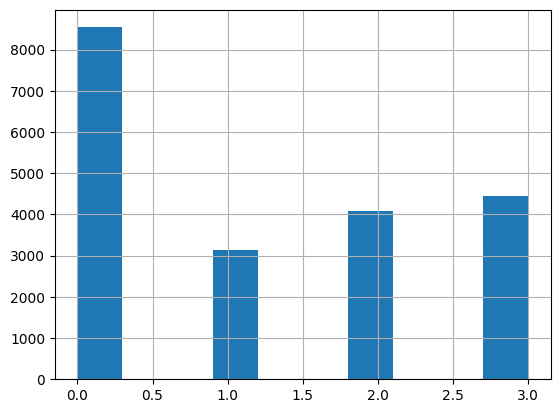

In [4]:
n_classes = 4
encoder = CitationRateEncoder(n_classes)
encoder.fit(df['target_citation_rate'])
df['target_citation_rate'] = df['target_citation_rate'].apply(encoder.transform)
df['target_citation_rate'].hist()
df.head()

We do some text preprocessing using stemming and stopwords removal

In [5]:
def preprocess_text(text: str):
    return re.sub(r'[^\w^\s]+', '', text).lower().split()


def easy_preprocess(text):
    return ' '.join(preprocess_text(str(text)))

nltk.download('stopwords')
stemmer = PorterStemmer()

def remove_stopwords(text: str):
    stopWords = set(stopwords.words('english'))
    return ' '.join([w for w in text.split() if w not in stopWords])


def medium_preprocess(text: str) -> list:
    return ' '.join([stemmer.stem(word) for word in text.split()])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
def full_text_preprocess(text: str):
    s_1 = easy_preprocess(text)
    s_2 = remove_stopwords(s_1)
    s_3 = medium_preprocess(s_2)
    return s_3

In [7]:
df['Preprocessed'] = df['Abstract'].apply(full_text_preprocess)
df

,Abstract,target_citation_rate,Preprocessed
Paper_ID,,,
1001,These are notes based on lectures given at TAS...,3,note base lectur given tasi99 review geometri ...
1002,We point out that massive gauged supergravity ...,3,point massiv gaug supergrav potenti exampl ari...
1003,"Recently, Ivanov and Volovich (hep-th/9912242)...",1,recent ivanov volovich hepth9912242 claim pert...
1004,"Quantum fields responding to ""moving mirrors"" ...",0,quantum field respond move mirror predict give...
1005,Various aspects of spaces of chiral blocks are...,0,variou aspect space chiral block discuss parti...
...,...,...,...
9912289,In a recent work we showed that for a Hamilton...,2,recent work show hamiltonian system constraint...
9912290,We discuss shuffle identities between Feynman ...,1,discuss shuffl ident feynman graph use hopf al...
9912291,We show a simple way of deriving the Casimir P...,2,show simpl way deriv casimir polder interact p...


First way is to get text embeddings using `CountVectorizer` and use them as input of `LogisticRegression` model to classify papers:

In [8]:
bow = CountVectorizer()
x_train = bow.fit_transform(df.loc[train]['Preprocessed'])
x_test = bow.transform(df.loc[test]['Preprocessed'])
y_train = df.loc[train]['target_citation_rate']
y_test = df.loc[test]['target_citation_rate']

In [9]:
log_reg = LogisticRegression(max_iter=1000).fit(x_train, y_train)

In [10]:
print("CountVectorizer embeddings:")
print("Logistic regression:\n", classification_report(y_test, log_reg.predict(x_test)))

CountVectorizer embeddings:
Logistic regression:
               precision    recall  f1-score   support

           0       0.57      0.66      0.61       885
           1       0.20      0.14      0.17       298
           2       0.24      0.22      0.23       385
           3       0.51      0.49      0.50       453

    accuracy                           0.46      2021
   macro avg       0.38      0.38      0.38      2021
weighted avg       0.44      0.46      0.45      2021



More elaborate way is to use `Word2Vec` to get the embeddings (they are already precalculated in `get_text_embeddings.ipynb`)

In [11]:
word2vec_embs_path = os.path.join(os.pardir, 'data', 'embeddings_50.npy')
word2vec_embs = np.load(word2vec_embs_path)
df['word2vec_embeddings'] = list(word2vec_embs)
df.head()

,Abstract,target_citation_rate,Preprocessed,word2vec_embeddings
Paper_ID,,,,
1001,These are notes based on lectures given at TAS...,3,note base lectur given tasi99 review geometri ...,"[0.07710943936411586, 0.017732303437842427, 0...."
1002,We point out that massive gauged supergravity ...,3,point massiv gaug supergrav potenti exampl ari...,"[0.08560000834107592, 0.0014293290410204089, -..."
1003,"Recently, Ivanov and Volovich (hep-th/9912242)...",1,recent ivanov volovich hepth9912242 claim pert...,"[0.06882751917308004, 0.03572695514768097, -0...."
1004,"Quantum fields responding to ""moving mirrors"" ...",0,quantum field respond move mirror predict give...,"[0.08449108820534139, 0.01706996641336109, -0...."
1005,Various aspects of spaces of chiral blocks are...,0,variou aspect space chiral block discuss parti...,"[0.07200555902580397, 0.03283976057829691, -0...."


In [12]:
x_train = np.array(df.loc[train]['word2vec_embeddings'].tolist())
x_test = np.array(df.loc[test]['word2vec_embeddings'].tolist())

In [13]:
log_reg = LogisticRegression(max_iter=1000).fit(x_train, y_train)

In [14]:
print("word2vec embeddings:")
print("Logistic regression:\n", classification_report(y_test, log_reg.predict(x_test)))

word2vec embeddings:
Logistic regression:
               precision    recall  f1-score   support

           0       0.44      1.00      0.61       885
           1       0.00      0.00      0.00       298
           2       0.50      0.00      0.01       385
           3       1.00      0.00      0.01       453

    accuracy                           0.44      2021
   macro avg       0.48      0.25      0.16      2021
weighted avg       0.51      0.44      0.27      2021



/mnt/d/Homework/5_semester/Сети/Project/hse-sna-project/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/d/Homework/5_semester/Сети/Project/hse-sna-project/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/d/Homework/5_semester/Сети/Project/hse-sna-project/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

And finally we can try using graph embeddings that were calculated using `Node2Vec`

In [15]:
graph_embs_path = os.path.join(os.pardir, 'data', 'n2c_embs')
node_embeddings = KeyedVectors.load_word2vec_format(graph_embs_path)
df['graph_embeddings'] = df.index.map(lambda x: node_embeddings[str(x)])

In [16]:
x_train = np.array(df.loc[train]['graph_embeddings'].tolist())
x_test = np.array(df.loc[test]['graph_embeddings'].tolist())

In [17]:
log_reg = LogisticRegression(max_iter=1000, random_state=10, solver='sag').fit(x_train, y_train)

In [18]:
print("Graph embeddings:")
print("Logistic regression:\n", classification_report(y_test, log_reg.predict(x_test)))

Graph embeddings:
Logistic regression:
               precision    recall  f1-score   support

           0       0.54      0.90      0.68       885
           1       0.00      0.00      0.00       298
           2       0.25      0.04      0.07       385
           3       0.54      0.58      0.56       453

    accuracy                           0.53      2021
   macro avg       0.33      0.38      0.33      2021
weighted avg       0.41      0.53      0.43      2021

